In [3]:
#load .npy
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import random
import os
ccm_file = '/home/alingold/Training/optrode_cross_section_plant/ccm_optrode_plant_128_allnorm_ccm1_128'
ref_file = '/home/alingold/Training/20231012_tile_ref'
ccm_imgs = np.load(ccm_file + '.npy')
ref_imgs = np.load(ref_file + '.npy')
# plt.imshow(ccm_imgs[1, :, :, 1] - ccm_imgs[1, :, :, 2])
#reshape_shape = [512, 512]
#Dir = '/media/alingold/MenonLab/20230418'
#Len = len(os.listdir(Dir)) - 3
#shape = (Len, reshape_shape[0], reshape_shape[1])

print(np.shape(ccm_imgs)), print(np.shape(ref_imgs)),

(26088, 128, 128)
(420, 256, 256)


(None, None)

In [1]:
# load .dat
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import random
import os
# File paths
ccm_file = '/home/alingold/Training/optrode_cross_section_plant/ccm_optrode_plant_128_allnorm_ccm1_128.npy'
ref_file = '/home/alingold/Training/20230919_oldTestTile_ref'

# Calculate number of images
ccm_size = np.memmap(ccm_file + '.dat', dtype=np.single, mode="r+").size
ref_size = np.memmap(ref_file + '.dat', dtype=np.single, mode="r+").size

# Given that each image is 256x256, calculate the number of images
ccm_num_images = ccm_size // (256 * 256)
ref_num_images = ref_size // (256 * 256)

# Shape of each array
ccm_shape = (ccm_num_images, 256, 256)
ref_shape = (ref_num_images, 256, 256)

# Load the memory-mapped arrays with the correct shape
ccm_imgs = np.memmap(ccm_file + '.dat', dtype=np.single, mode="r", shape=ccm_shape)
ref_imgs = np.memmap(ref_file + '.dat', dtype=np.single, mode="r", shape=ref_shape)

#ccm_imgs = ccm_imgs[1000:2000, :, :]
#ref_imgs = ref_imgs[1000:2000, :, :]

# Check the shapes
print("Shape of ccm_imgs:", np.shape(ccm_imgs))
print("Shape of ref_imgs:", np.shape(ref_imgs))

FileNotFoundError: [Errno 2] No such file or directory: '/home/alingold/Training/optrode_cross_section_plant/ccm_optrode_plant_128_allnorm_ccm1_128.npy.dat'

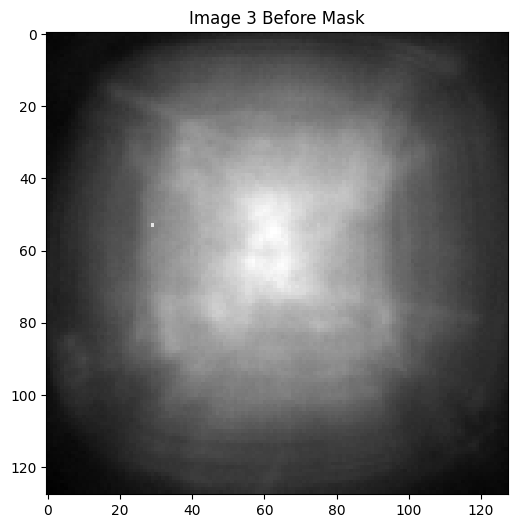

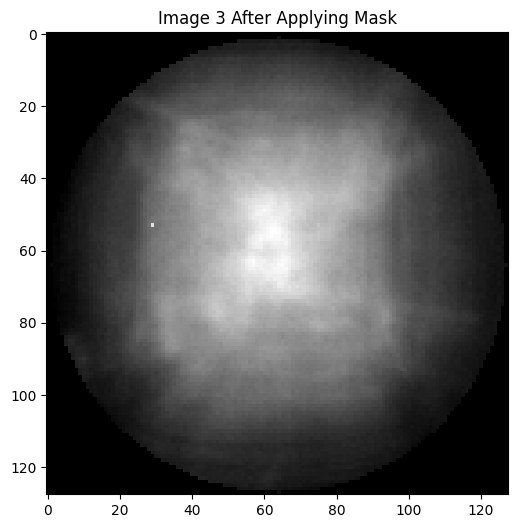

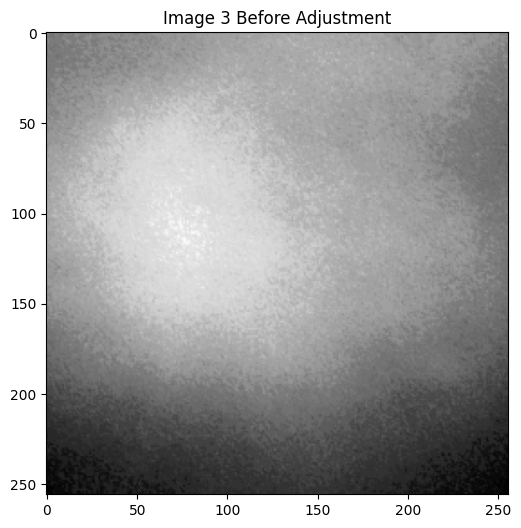

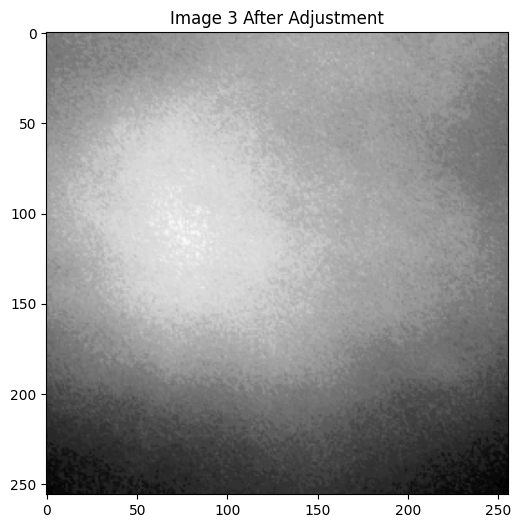

(420, 256, 256)
0.0
1.0
(26088, 128, 128)
0.0
1.0
Saving files /home/alingold/Training/optrode_cross_section_plant/ccm_optrode_plant_128_allnorm_ccm1_128_pro.npy and /home/alingold/Training/20231012_tile_ref_pro.npy...


In [4]:
'''
def apply_circular_mask(images, center_x, center_y, mask_diameter):
    masked_images = []
    for image in images:
        rows, cols = image.shape[:2]
        mask = np.zeros((rows, cols), dtype=np.uint8)
        cv2.circle(mask, (center_x, center_y), int(mask_diameter / 2), 1, -1)
        mask_3d = np.repeat(mask[:, :, np.newaxis], 3, axis=2) if len(image.shape) == 3 else mask
        masked_image = ma.masked_array(image, mask=1 - mask_3d)

        if len(image.shape) == 3:  # Color image
            min_value_within_mask = masked_image.min(axis=(0, 1))
            A_reshaped = masked_image.reshape(-1)
            sorted_values = np.sort(A_reshaped)[::-1]
            max_value_within_mask = sorted_values[1]
            
            for i in range(3):  # Normalize each channel
                image[..., i] = (image[..., i] - min_value_within_mask[i]) / (max_value_within_mask[i] - min_value_within_mask[i])
        else:  # Grayscale image
            min_value_within_mask = masked_image.min()
            # max_value_within_mask = masked_image.max()
            A_reshaped = masked_image.reshape(-1)
            sorted_values = np.sort(A_reshaped)[::-1]
            max_value_within_mask = sorted_values[1]
            print(max_value_within_mask)
            image = (image - min_value_within_mask) / (max_value_within_mask - min_value_within_mask)

        masked_image = image * mask_3d
        masked_images.append(masked_image)

    return np.array(masked_images)
'''    
def apply_circular_mask(images, center_x, center_y, mask_diameter):
    masked_images = []
    for image in images:
        rows, cols = image.shape[:2]
        mask = np.zeros((rows, cols), dtype=np.uint8)
        cv2.circle(mask, (center_x, center_y), int(mask_diameter / 2), 1, -1)
        mask_3d = np.repeat(mask[:, :, np.newaxis], 3, axis=2) if len(image.shape) == 3 else mask
        masked_image = ma.masked_array(image, mask=1 - mask_3d)

        if len(image.shape) == 3:  # Color image
            min_value_within_mask = masked_image.min(axis=(0, 1))
            sorted_values_within_mask = np.sort(masked_image.compressed())[::-1]
            max_value_within_mask = sorted_values_within_mask[1]
            
            for i in range(3):  # Normalize each channel
                image[..., i] = (image[..., i] - min_value_within_mask[i]) / (max_value_within_mask[i] - min_value_within_mask[i])
        else:  # Grayscale image
            min_value_within_mask = masked_image.min()
            sorted_values_within_mask = np.sort(masked_image.compressed())[::-1]
            max_value_within_mask = sorted_values_within_mask[1]
            image = (image - min_value_within_mask) / (max_value_within_mask - min_value_within_mask)

        masked_image_result = image * mask_3d
        masked_images.append(masked_image_result)

    return np.array(masked_images)


def remove_blurry_images(ref_imgs, ccm_imgs, blIndex, min_threshold, max_threshold, min_fft_threshold, show_samples=True, num_samples=10):
    non_blurry_ref_imgs = []
    non_blurry_ccm_imgs = []
    num_images = len(ref_imgs)
    sample_indices = random.sample(range(num_images), min(num_images, num_samples))

    for i, ref_img in enumerate(ref_imgs):
        laplacian = cv2.Laplacian((ref_img * 255).astype(np.uint8), cv2.CV_64F).var()
        f = np.fft.fft2(ref_img)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = np.abs(20*np.log(np.abs(fshift)))
        mean_magnitude_spectrum = magnitude_spectrum.mean()
        
        blurry_laplacian = laplacian < min_threshold or laplacian > max_threshold
        blurry_fft = mean_magnitude_spectrum < min_fft_threshold
        
        if show_samples and i in sample_indices:
            plt.figure(figsize=(10, 5))
            plt.imshow(ref_img, cmap='gray')
            plt.title(f'Image {i+1}: {"Blurry" if blurry_laplacian or blurry_fft else "Not Blurry"}, Laplacian: {laplacian}, Mean FFT Magnitude: {mean_magnitude_spectrum}')
            plt.show()
            
        if not blurry_laplacian and not blurry_fft:
            non_blurry_ref_imgs.append(ref_img)
            non_blurry_ccm_imgs.append(ccm_imgs[i])
            blIndex[i] = 1

    return np.array(non_blurry_ref_imgs), np.array(non_blurry_ccm_imgs)

def remove_blurry_images_info(ref_imgs, ccm_imgs, blIndex, min_threshold, max_threshold, min_fft_threshold, show_samples=True, num_samples=10):
    non_blurry_ref_imgs = []
    non_blurry_ccm_imgs = []
    num_images = len(ref_imgs)
    sample_indices = random.sample(range(num_images), min(num_images, num_samples))
    blurry_laplacian_count = 0
    blurry_fft_count = 0

    for i, ref_img in enumerate(ref_imgs):
        laplacian = cv2.Laplacian((ref_img * 255).astype(np.uint8), cv2.CV_64F).var()
        f = np.fft.fft2(ref_img)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = np.abs(20*np.log(np.abs(fshift)))
        mean_magnitude_spectrum = magnitude_spectrum.mean()
        
        blurry_laplacian = laplacian < min_threshold or laplacian > max_threshold
        blurry_fft = mean_magnitude_spectrum < min_fft_threshold

        if blurry_laplacian:
            blurry_laplacian_count += 1
        if blurry_fft:
            blurry_fft_count += 1
            
        if show_samples and i in sample_indices:
            plt.figure(figsize=(10, 5))
            plt.imshow(ref_img, cmap='gray')
            plt.title(f'Image {i+1}: {"Blurry" if blurry_laplacian or blurry_fft else "Not Blurry"}, Laplacian: {laplacian}, Mean FFT Magnitude: {mean_magnitude_spectrum}')
            plt.show()
            
        if not blurry_laplacian and not blurry_fft:
            non_blurry_ref_imgs.append(ref_img)
            non_blurry_ccm_imgs.append(ccm_imgs[i])
            blIndex[i] = 1

    print(f"Blurry by laplacian: {blurry_laplacian_count}")
    print(f"Blurry by fft: {blurry_fft_count}")
    print(f"Total non blurry images: {len(non_blurry_ref_imgs)}")

    return np.array(non_blurry_ref_imgs), np.array(non_blurry_ccm_imgs)



def normalize_images(ref_imgs, black_point, ccm):
    ref_imgs_normalized = np.zeros_like(ref_imgs)
    for i in range(ref_imgs.shape[0]):
        img = ref_imgs[i]
        #if ccm == 1: # check if it is ccm
            #img[ 92, 232] = 0.1 # fix broken pixel
            #img[90, 219] = 0.1
            #img[90, 220] = 0.1
            #img[89, 219] = 0.1
            #img[89, 220] = 0.1
        # Flatten the image to 1D array
        flat = img.flatten()
        # Sort the pixel intensities in ascending order
        sorted_pixels = np.sort(flat)
        # Compute the index of the black point
        black_index = int(black_point * len(sorted_pixels))
        # Set the black point as the intensity value below which all pixels will be considered black
        black_intensity = sorted_pixels[black_index]
        # Shift the intensity histogram to make the black point the new minimum
        img_shifted = img - black_intensity
        # Clip the intensities to the range [0, 1]
        img_shifted = np.clip(img_shifted, 0, None)
        # Normalize the intensities to the range [0, 1]
        img_min = img_shifted.min()
        img_max = img_shifted.max()
        ref_imgs_normalized[i] = (img_shifted - img_min) / (img_max - img_min)

    return ref_imgs_normalized


def display_images(ref_imgs, ref_imgs_pro, ccm_imgs, ccm_imgs_pro):
    example_index = 2 

    plt.figure(figsize=(6, 6))
    plt.imshow(ccm_imgs[example_index], cmap='gray')
    plt.title(f'Image {example_index+1} Before Mask')
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.imshow(ccm_imgs_pro[example_index], cmap='gray')
    plt.title(f'Image {example_index+1} After Applying Mask')
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.imshow(ref_imgs[example_index], cmap='gray')
    plt.title(f'Image {example_index+1} Before Adjustment')
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.imshow(ref_imgs_pro[example_index], cmap='gray')
    plt.title(f'Image {example_index+1} After Adjustment')
    plt.show()
    
def save_parameters_to_txt(filename, parameters):
    with open(filename, 'w') as f:
        for key, value in parameters.items():
            f.write(f'{key}: {value}\n')

    
def main():
    max_threshold = 200
    min_threshold = 20
    min_fft_threshold = 20
    center_x = 64 #127
    center_y = 64 #128
    mask_diameter = 126 #240
    gamma = 1
    black_point = 0
    
    ccm_imgs_pro = ccm_imgs
    ref_imgs_pro = ref_imgs
    
    blIndex = np.ones((len(ref_imgs_pro), ), dtype=bool)
    
    
    #ref_imgs_pro, ccm_imgs_pro = remove_blurry_images_info(ref_imgs_pro, ccm_imgs_pro, blIndex, min_threshold, max_threshold, min_fft_threshold)
    ccm_imgs_pro = apply_circular_mask(ccm_imgs_pro, center_x, center_y, mask_diameter)  # Apply circular mask

    #ref_imgs_pro = np.power(ref_imgs_pro, 1/gamma)
    #ref_imgs_pro = (ref_imgs_pro * np.max(ref_imgs_pro)).astype(ref_imgs_pro.dtype)

    ref_imgs_pro = normalize_images(ref_imgs_pro, black_point, 0)
    ccm_imgs_pro = normalize_images(ccm_imgs_pro, 0, 1)

    display_images(ref_imgs, ref_imgs_pro, ccm_imgs, ccm_imgs_pro)

    print(np.shape(ref_imgs_pro))
    print(np.min(ref_imgs_pro))
    print(np.max(ref_imgs_pro))
    print(np.shape(ccm_imgs_pro))
    print(np.min(ccm_imgs_pro))
    print(np.max(ccm_imgs_pro))
    

    parameters = {
        'max_threshold': max_threshold,
        'min_threshold': min_threshold,
        'min_fft_threshold': min_fft_threshold,
        'center_x': center_x,
        'center_y': center_y,
        'mask_diameter': mask_diameter,
        'gamma': gamma,
        'black_point': black_point,
        # 'blIndex': blIndex,
        'ref_shape': np.shape(ref_imgs_pro),
    }

    return ref_imgs_pro, ccm_imgs_pro, blIndex, parameters

if __name__ == "__main__":
    ref_imgs_pro, ccm_imgs_pro, blIndex, parameters = main()  # Capture the returned variables

    # Save the non-blurry images as numpy arrays
    np.save(ccm_file + '_pro.npy', ccm_imgs_pro)
    np.save(ref_file + '_pro.npy', ref_imgs_pro)
     # Call the function to save the parameters
    save_parameters_to_txt(ref_file + '_pro.txt', parameters)

    # Save the blIndex array
    # np.save(ref_file + 'blIndex.npy') #nd application. However, by following these techniques, you can improve the performance of your code and make it more efficient.
    
    print(f'Saving files {ccm_file + "_pro.npy"} and {ref_file + "_pro.npy"}...')


In [5]:
# this works with memory mapping

def normalize_images(ref_imgs, black_point, ccm):
    ref_imgs_normalized = np.zeros_like(ref_imgs)
    for i in range(ref_imgs.shape[0]):
        img = np.copy(ref_imgs[i])
        if ccm == 1: # check if it is ccm
            img[ 92, 232] = 0.1 # fix broken pixel
        # Flatten the image to 1D array
        flat = img.flatten()
        # Sort the pixel intensities in ascending order
        sorted_pixels = np.sort(flat)
        # Compute the index of the black point
        black_index = int(black_point * len(sorted_pixels))
        # Set the black point as the intensity value below which all pixels will be considered black
        black_intensity = sorted_pixels[black_index]
        # Shift the intensity histogram to make the black point the new minimum
        img_shifted = img - black_intensity
        # Clip the intensities to the range [0, 1]
        img_shifted = np.clip(img_shifted, 0, None)
        # Normalize the intensities to the range [0, 1]
        img_min = img_shifted.min()
        img_max = img_shifted.max()
        ref_imgs_normalized[i] = (img_shifted - img_min) / (img_max - img_min)
    return ref_imgs_normalized

def apply_circular_mask(images, center_x, center_y, mask_diameter):
    masked_images = []
    for image in images:
        rows, cols = image.shape[:2]
        mask = np.zeros((rows, cols), dtype=np.uint8)
        cv2.circle(mask, (center_x, center_y), int(mask_diameter / 2), 1, -1)
        mask_3d = np.repeat(mask[:, :, np.newaxis], 3, axis=2) if len(image.shape) == 3 else mask
        masked_image = ma.masked_array(image, mask=1 - mask_3d)

        if len(image.shape) == 3:  # Color image
            min_value_within_mask = masked_image.min(axis=(0, 1))
            sorted_values_within_mask = np.sort(masked_image.compressed())[::-1]
            max_value_within_mask = sorted_values_within_mask[1]
            
            for i in range(3):  # Normalize each channel
                image[..., i] = (image[..., i] - min_value_within_mask[i]) / (max_value_within_mask[i] - min_value_within_mask[i])
        else:  # Grayscale image
            min_value_within_mask = masked_image.min()
            sorted_values_within_mask = np.sort(masked_image.compressed())[::-1]
            max_value_within_mask = sorted_values_within_mask[1]
            if max_value_within_mask != min_value_within_mask:
                image = (image - min_value_within_mask) / (max_value_within_mask - min_value_within_mask)
                if np.any(np.isnan(image)) or np.any(np.isinf(image)):
                    print(f"Warning: Encountered NaN or Inf values in image at index {len(masked_images)}.")
            #else:
                #print(f"Warning: Skipping normalization for image at index {len(masked_images)} because max and min values within mask are the same.")
            #image = (image - min_value_within_mask) / (max_value_within_mask - min_value_within_mask)

        masked_image_result = image * mask_3d
        masked_images.append(masked_image_result)

    return np.array(masked_images)


def apply_circular_mask_to_mmap(src_mmap_array, dest_mmap_array, center_x, center_y, mask_diameter, chunk_size=10):
    for i in range(0, len(src_mmap_array), chunk_size):
        # Process a chunk and write it to dest_mmap_array
        chunk = apply_circular_mask(src_mmap_array[i:i+chunk_size], center_x, center_y, mask_diameter)
        dest_mmap_array[i:i+chunk_size] = chunk


def normalize_images_to_mmap(src_mmap_array, dest_mmap_array, black_point, ccm, chunk_size=10):
    for i in range(0, len(src_mmap_array), chunk_size):
        # Process a chunk and write it to dest_mmap_array
        chunk = normalize_images(src_mmap_array[i:i+chunk_size], black_point, ccm)
        dest_mmap_array[i:i+chunk_size] = chunk

# Create memory-mapped array for storing processed ccm images
ccm_imgs_pro = np.memmap(ccm_file + '_pro' + '.dat', dtype=np.single, mode="w+", shape=ccm_shape)

# Create memory-mapped array for storing processed ref images
ref_imgs_pro = np.memmap(ref_file + '_pro' + '.dat', dtype=np.single, mode="w+", shape=ref_shape)


center_x = 127
center_y = 128
mask_diameter = 240
black_point = 0

apply_circular_mask_to_mmap(ccm_imgs, ccm_imgs_pro, center_x, center_y, mask_diameter)
normalize_images_to_mmap(ref_imgs, ref_imgs_pro, black_point, 0)
normalize_images_to_mmap(ccm_imgs, ccm_imgs_pro, 0, 1)


/tmp/ipykernel_374559/434930461.py:24: RuntimeWarning: invalid value encountered in divide
  ref_imgs_normalized[i] = (img_shifted - img_min) / (img_max - img_min)


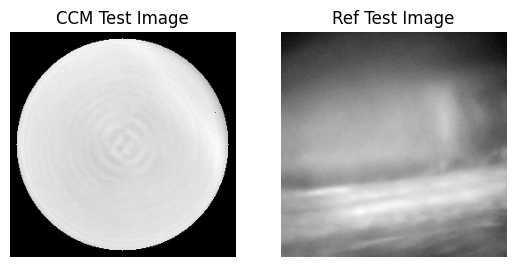

In [6]:
#view images from memory mapped arrays
import numpy as np
import matplotlib.pyplot as plt

# Assuming ccm_imgs and ref_imgs are your memory-mapped arrays
# Extract a single test image
test_image_ccm = ccm_imgs_pro[2]
test_image_ref = ref_imgs_pro[2]

# Reshape the images to have the expected shape (1, height, width, channels)
test_image_ccm = np.expand_dims(test_image_ccm, axis=0)
test_image_ref = np.expand_dims(test_image_ref, axis=0)

# Apply your functions

test_image_ccm = apply_circular_mask(test_image_ccm, center_x=127, center_y=128, mask_diameter=240)
test_image_ccm = normalize_images(test_image_ccm, black_point=0, ccm=1)
test_image_ref = normalize_images(test_image_ref, black_point=0, ccm=0)

# Optionally, visualize the test image
plt.figure()
plt.subplot(1, 2, 1)
plt.title('CCM Test Image')
plt.imshow(test_image_ccm[0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ref Test Image')
plt.imshow(test_image_ref[0], cmap='gray')
plt.axis('off')

plt.show()

In [2]:
# Assuming ccm_imgs_pro is a 3D numpy array and example_index is an integer
example_image = ccm_imgs_pro[10]

# Find the flattened index of the maximum value in example_image
max_index_flattened = np.argmax(example_image)

# Convert the flattened index to 2D coordinates
max_coords = np.unravel_index(max_index_flattened, example_image.shape)

print("Coordinates of maximum value:", max_coords)
print("maximum value:", max_index_flattened)

NameError: name 'ccm_imgs_pro' is not defined